# Convert results of Holschuh et al., 2019 to xarray and upload to ldeo-glaciology google bucket
Data can be found and downloaded here: 

Paper can be found here: 

Code to plot figures from the paper can be found here: 

In [1]:
import numpy as np
import xarray as xr
# import json
# import gcsfs
import os
import scipy.io as spio
import matplotlib.pyplot as plt

rho_ow = 1028   # density of ocean water
rho_ice = 917   # density of ice

## load melt rate data from h5 file. 

In [100]:
filepath = '/Users/dporter/data/Antarctic/DEM/Holschuh2019_Thwaites'

which_grid = 'Upstream'  # 'Upstream' Downstream

filename ='GriddedBed_' + which_grid + '.mat'
matdata = spio.loadmat(os.path.join(filepath, filename)) # filename ='GriddedBed_Upstream.mat'

print(matdata.keys())


dict_keys(['__header__', '__version__', '__globals__', 'bed_elev', 'lat', 'long', 'x_coord', 'y_coord'])


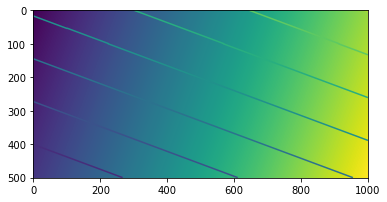

In [3]:
plt.imshow(matdata['x_coord'])
plt.contour(matdata['y_coord'])

### extract coordinates and data array

In [4]:
x_coord = np.array(matdata['x_coord'])
y_coord = np.array(matdata['y_coord'])
bedelev = np.array(matdata['bed_elev'])
# x_coord = x_coord[:,0]
# y_coord = y_coord[0,:]

lat = np.array(matdata['lat'])
lon = np.array(matdata['long'])

In [41]:
print(bedelev.shape)
print(x_coord.shape)
print(y_coord.shape)

(501, 1001)
(501, 1001)
(501, 1001)


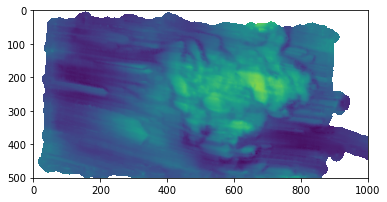

In [10]:
plt.imshow(bedelev)

### create xarray from data

In [45]:
# ds_bed = xr.DataArray(bedelev, dims=("y", "x"), coords={"y": y_coord,"x": x_coord})   

In [46]:
ds_bed = xr.DataArray(bedelev,coords={"x_EPSG": (["x","y"], x_coord),
                                      "y_EPSG": (["x","y"], y_coord)},
                                      dims=["x","y"])

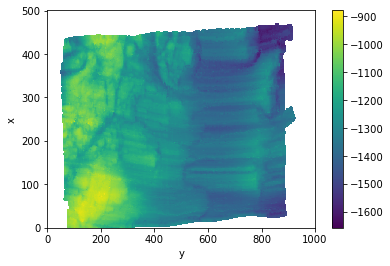

In [47]:
ds_bed.plot()

## That was upside down!

'flipud' the y_coord? Nope, that's wrong.  Flip the data ud!

In [51]:
# y_coord = np.flipud(y_coord)

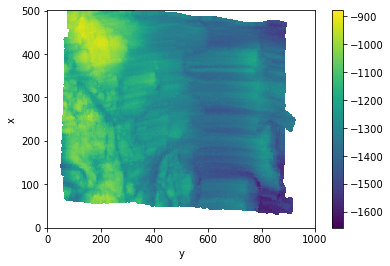

In [52]:
ds_bed = xr.DataArray(np.flipud(bedelev),coords={"x_EPSG": (["x","y"], x_coord),
                                      "y_EPSG": (["x","y"], y_coord)},
                                      dims=["x","y"])

ds_bed.plot()

### plot to check that everything looks correct 
(TODO: check more thoroughly that the coordinate system is correct)

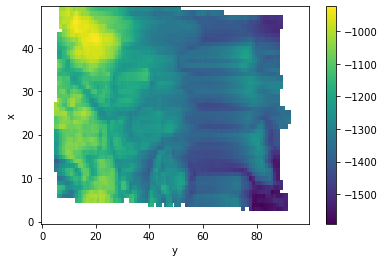

In [53]:
ds_bed.coarsen(x=10, y=10, boundary="trim").mean().plot()

In [54]:
# bed_coarse = ds_bed.coarsen(x=2, y=2, boundary="trim").mean()
# print(np.shape(melt.values))
# print(np.shape(melt_coarse.values))

In [55]:
ds_bed['x_EPSG'][-2:,0]

<xarray.DataArray 'x_EPSG' (x: 2)>
array([-1320509.95531879, -1320500.57709374])
Coordinates:
    x_EPSG   (x) float64 -1.321e+06 -1.321e+06
    y_EPSG   (x) float64 -4.63e+05 -4.63e+05
Dimensions without coordinates: x

### get resolutions of data

In [56]:
resolution = (ds_bed['x_EPSG'][1,0]-ds_bed['x_EPSG'][0,0]).squeeze().astype(int).values
print(resolution)

9


### plot coarsened data

In [57]:
# import cartopy.crs
# import cartopy.crs as ccrs
# import matplotlib.path as mpath
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=[10, 10])
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

# fig.subplots_adjust(bottom=0.05, top=0.95,
#                     left=0.04, right=0.95, wspace=0.02)

# ax.set_extent((160, 210, -82, -70), crs=cartopy.crs.PlateCarree())

# ax.pcolormesh(melt_coarse['x'].squeeze(), melt_coarse['y'].squeeze(), 
#               melt_coarse.values,
#               vmin=-6, vmax=6, cmap='RdBu_r')


# ax.coastlines(resolution='10m')

# gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)
# gl.n_steps = 90

# # This bit of code sets a circular boundary for nice pan-polar figures
# # theta = np.linspace(0, 2*np.pi, 100)
# # center, radius = [0.5, 0.5], 0.5
# # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# # circle = mpath.Path(verts * radius + center)
# # ax.set_boundary(circle, transform=ax.transAxes)

# plt.show()




### write to ascii grid

In [58]:
#  need to flip data array

outvar = 'bedelev'
array_out = np.nan_to_num(np.flip(ds_bed.values, 0), nan=-9999)
# array_out

In [59]:
ds_bed['x']

<xarray.DataArray 'x' (x: 501)>
array([  0,   1,   2, ..., 498, 499, 500])
Dimensions without coordinates: x

In [60]:
print(ds_bed['x_EPSG'][0,0].values.astype(int))

-1325189


In [61]:
# xllcorner    -2736000 
# yllcorner    -2740000

header = "ncols     %s\n" % array_out.shape[1]
header += "nrows    %s\n" % array_out.shape[0]
header += "xllcorner %s\n" % ds_bed['x_EPSG'][0,0].values.astype(int)
header += "yllcorner %s\n" % ds_bed['y_EPSG'][0,0].values.astype(int)
header += "cellsize %s\n" % resolution
header += "NODATA_value -9999\n"

np.savetxt(f"data/Holschuh_2019_{which_grid}-{resolution}m_{outvar}.asc", 
           array_out, header=header, comments='')#, fmt="%d")  #fmt="%1.2f")

## Try writing to geotiff using GDAL?

In [101]:
x_coord = np.array(matdata['x_coord']).T
y_coord = np.array(matdata['y_coord']).T
bedelev = np.array(matdata['bed_elev']).T
# x_coord = x_coord[:,0]
# y_coord = y_coord[0,:]

lat = np.array(matdata['lat']).T
lon = np.array(matdata['long']).T

In [102]:
# # For each pixel I know it's latitude and longitude.
# # As you'll see below you only really need the coordinates of
# # one corner, and the resolution of the file.

# xmin,ymin,xmax,ymax = [lon.min(),lat.min(),lon.max(),lat.max()]
# nrows,ncols = np.shape(array)
# xres = (xmax-xmin)/float(ncols)
# yres = (ymax-ymin)/float(nrows)
# geotransform=(xmin,xres,0,ymax,0, -yres)   
# # That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
# #         top left y, rotation (0 if North is up), n-s pixel resolution)
# # I don't know why rotation is in twice???

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(array)   # Writes my array to the raster

# output_raster.FlushCache()

In [103]:
# geotransform needs coordinates of one corner and the resolution of the file
xmin, ymin, xmax, ymax = [lon.min(), lat.min(), lon.max(), lat.max()]
# xmin, ymin, xmax, ymax = [lat.max(), lon.max(), lat.min(), lon.min()]
nrows, ncols = np.shape(bedelev)
xres = (xmax - xmin) / float(ncols)
yres = (ymax - ymin) / float(nrows)
geotransform = (xmin, xres, 0, ymax, 0, -yres)
# That's (top left x, w-e pixel resolution, rotation (0 if North is up),
#         top left y, rotation (0 if North is up), n-s pixel resolution)



In [104]:
# bedelev[np.isnan(bedelev)] = -9999

In [105]:
bedelev.astype('int')

array([[-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808],
       [-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808],
       [-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808],
       ...,
       [-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808],
       [-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808],
       [-9223372036854775808, -9223372036854775808, -9223372036854775808,
        ..., -9223372036854775808, -9223372036854775808,
        -9223372036854775808]])

In [106]:
bedelev.astype('int').dtype

dtype('int64')

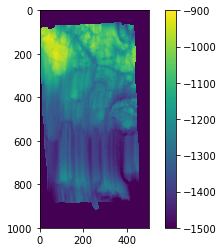

In [107]:
plt.imshow(bedelev.astype('int'),vmin=-1500,vmax=-900)
plt.colorbar()

In [108]:
bedelev_flipped = np.nan_to_num(np.fliplr(bedelev), nan=-9999)
# bedelev_flipped = np.nan_to_num(np.flip(bedelev, 1), nan=-9999)

In [109]:
from osgeo import gdal, gdal_array, osr

output_raster = gdal.GetDriverByName('GTiff').Create('myraster_T_upstream.tif',ncols, nrows, 1 ,gdal.GDT_Float32)  # gdal.GDT_Int32
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates


0

In [110]:
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.

output_raster.SetProjection(srs.ExportToWkt())   # Exports the coordinate system to the file
output_raster.GetRasterBand(1).SetNoDataValue(-9999)
output_raster.GetRasterBand(1).WriteArray(bedelev_flipped)   # Writes my array to the raster
output_raster.GetRasterBand(1).FlushCache()
# output_raster.GetRasterBand(1).ComputeStatistics(False)

output_raster = None 

### Use Projected (e.g. EPSG 3031) instead

In [65]:
# geotransform needs coordinates of one corner and the resolution of the file
xmin, ymin, xmax, ymax = [x_coord.min(), y_coord.min(), x_coord.max(), y_coord.max()]
nrows, ncols = np.shape(bedelev)
xres = (xmax - xmin) / float(ncols)
yres = (ymax - ymin) / float(nrows)
geotransform = (xmin, xres, 0, ymax, 0, -yres)
# That's (top left x, w-e pixel resolution, rotation (0 if North is up),
#         top left y, rotation (0 if North is up), n-s pixel resolution)



In [68]:
from osgeo import gdal, gdal_array, osr

output_raster = gdal.GetDriverByName('GTiff').Create('myraster_epsg.tif',ncols, nrows, 1 ,gdal.GDT_Int32)  # gdal.GDT_Float32
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates


0

In [70]:
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(3031)                     # This one specifies 3031 lat long.

output_raster.SetProjection(srs.ExportToWkt())   # Exports the coordinate system to the file
output_raster.GetRasterBand(1).SetNoDataValue(-9999)
output_raster.GetRasterBand(1).WriteArray(bedelev.astype('int'))   # Writes my array to the raster
output_raster.FlushCache()


In [71]:
geotransform

(-1436187.010976764,
 55.52298231417668,
 0,
 -431830.85690976784,
 0,
 -81.46597464734566)